In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth',-1)

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
import string
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras import backend as K
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [2]:
# Load csv file
df = pd.read_csv('datasets/review_yelp.csv', encoding='iso-8859-1', index_col=0)

In [3]:
df.head()

,text,sentiment
1,"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon! I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level! \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit. Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room. Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure. That was superb! Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen. The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement. It was so much fun to be there! \n\nNext Travis started with the flat iron. The way he flipped his wrist to get volume all around without over-doing it and making me look like a Texas pagent girl was admirable. It's also worth noting that he didn't fry my hair -- something that I've had happen before with less skilled stylists. At the end of the blowout & style my hair was perfectly bouncey and looked terrific. The only thing better? That this awesome blowout lasted for days! \n\nTravis, I will see you every single time I'm out in Vegas. You make me feel beauuuutiful!",1
2,"I have to say that this office really has it together, they are so organized and friendly! Dr. J. Phillipp is a great dentist, very friendly and professional. The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable! I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit! I highly recommend this office for the nice synergy the whole office has!",1
3,"Went in for a lunch. Steak sandwich was delicious, and the Caesar salad had an absolutely delicious dressing, with a perfect amount of dressing, and distributed perfectly across each leaf. I know I'm going on about the salad ... But it was perfect.\n\nDrink prices were pretty good.\n\nThe Server, Dawn, was friendly and accommodating. Very happy with her.\n\nIn summation, a great pub experience. Would go again!",1
5,"I'll be the first to admit that I was not excited about going to La Tavolta. Being a food snob, when a group of friends suggested we go for dinner I looked online at the menu and to me there was nothing special and it seemed overpriced. Im also not big on ordering pasta when I go out. Alas, I was outnumbered. Thank goodness! I ordered the sea bass special. It was to die for. Cooked perfectly, seasoned perfectly, perfect portion. I can not say enough good things about this dish. When the server asked how it was he seemed very proud of the dish and said, "" doesn't she (the chef) do an incredible job?"" She does. \n\nMy hubby got the crab tortellini and also loved his. I heard ""mmmm this is so good"" from all around the table. Our waiter was super nice and even gave us free desserts because we were some of the last people in the restaurant. Service was very slow and the place was PACKED but we had our jugs of wine and a large group with good conversation so it didn't seem to bother anyone.\n\nSo-\n\nDo order the calamari and fried zucchini appetizers. Leave out the mussels. \n\nIf they have the sea bass special, I highly recommend it. The chicken parm and crab tortellini were also very good and very big. The chicken Romano was a bit bland. The house salads were teeny. \n\nDo make a reservation but still expect to wait for your food. Go with a large group of peop

## Data Exploration

In [4]:
print("Total number of reviews: ",len(df))

Total number of reviews:  100000


In [ ]:
#Dividing the dataset into features and lables
reviews = df['text']
labels = df['sentiment']

In [ ]:
print("Max length of reviews")
print(pd.Series({c: df[c].map(lambda x: len(str(x))).max() for c in df}).sort_values(ascending =False))

In [ ]:
print("Average length of reviews")
df.fillna('').astype(str).apply(lambda x:x.str.len()).mean()

In [ ]:
#check the distribution of lebels

labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [ ]:
import nltk
from nltk.corpus import stopwords #To remove the stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
cachedStopWords = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

In [ ]:
def displayWordCloud(data,i):
  tweets = " ".join(data['text'][data['sentiment'] == i ])
  tweets = ' '.join([word.lower() for word in nltk.word_tokenize(tweets)])
  tweets = re.sub(r'[^a-zA-Z]',' ',tweets)#Remove numbers,puncutions
  tweets = " ".join(tweets.split())#to remove the spaces 
  tokens = nltk.word_tokenize(tweets)# Tokenize the Sentences
  tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in cachedStopWords and len(word) > 2]
  return nltk.FreqDist(tokens)

### Display wordcloud for negative sentences

In [ ]:
text = displayWordCloud(df, 0)
neg_wordcloud = WordCloud(width=500, height=300, random_state=21).generate_from_frequencies(text)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.show()

### display wordcloud for positive sentences

In [ ]:
text = displayWordCloud(df, 1)
neg_wordcloud = WordCloud(width=500, height=300, random_state=21).generate_from_frequencies(text)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.show()

## Train test split data

In [5]:
# Split data into training set and validation
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

Load 80000 training examples and 20000 validation examples. 

Show a review in the training set : 
 Today I went in for a massage bc I had slept wrong & my neck was killing me. I told this to Steve (my therapist) & that I go about every other week for massage. I reminded him many times during the massage about my neck, but tried not to be overly pushy. There were many times he did not follow my skeletal outline & with a lot of pressure just rolled over my scapula & other bones. When doing deep tissue I think it's rather important to stay on the tissue otherwise it can be a bit painful. I like a pretty intense massage & don't usually complain about it, but when it's done incorrectly it's frustrating. Towards the end I reminded him again about my neck. I tried & tried to explain & show him exactly where the spot is (& even how to massage it!), but he just acted like I was annoying him....with heavy sighs even! Seriously?! I came in bc my neck hurt & I had to leave with my neck still hurt

## Text Preprocessing

In [6]:
def cleanText(raw_text, remove_stopwords=True, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    text = text.translate(string.punctuation) #remove punctuation
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    words = " ".join(words)

    # Clean the text
    words = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", words)
    words = re.sub(r"what's", "what is ", words)
    words = re.sub(r"\'s", " ", words)
    words = re.sub(r"\'ve", " have ", words)
    words = re.sub(r"n't", " not ", words)
    words = re.sub(r"i'm", "i am ", words)
    words = re.sub(r"\'re", " are ", words)
    words = re.sub(r"\'d", " would ", words)
    words = re.sub(r"\'ll", " will ", words)
    words = re.sub(r",", " ", words)
    words = re.sub(r"\.", " ", words)
    words = re.sub(r"!", " ! ", words)
    words = re.sub(r"\/", " ", words)
    words = re.sub(r"\^", " ^ ", words)
    words = re.sub(r"\+", " + ", words)
    words = re.sub(r"\-", " - ", words)
    words = re.sub(r"\=", " = ", words)
    words = re.sub(r"'", " ", words)
    words = re.sub(r"(\d+)(k)", r"\g<1>000", words)
    words = re.sub(r":", " : ", words)
    words = re.sub(r" e g ", " eg ", words)
    words = re.sub(r" b g ", " bg ", words)
    words = re.sub(r" u s ", " american ", words)
    words = re.sub(r"\0s", "0", words)
    words = re.sub(r" 9 11 ", "911", words)
    words = re.sub(r"e - mail", "email", words)
    words = re.sub(r"j k", "jk", words)
    words = re.sub(r"\s{2,}", " ", words)
    
    words = words.split()
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = PorterStemmer() 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [7]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))
print('\nShow a cleaned review in the testing set : \n', X_test_cleaned[10])

/usr/local/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Show a cleaned review in the training set : 
 today went massage bc slept wrong neck killing told steve therapist go every week massage reminded many times massage neck tried overly pushy many times follow skeletal outline lot pressure rolled scapula bones deep tissue think rather important stay tissue otherwise bit painful like pretty intense massage usually complain done incorrectly frustrating towards end reminded neck tried tried explain show exactly spot even massage acted like annoying heavy sighs even seriously came bc neck hurt leave neck still hurting unacceptable

Show a cleaned review in the testing set : 
 journey electric small project us extremely happy work cost electrician polite knowledgeable efficient definitely use


## Parsing review into list of sentences for Word2vec

In [8]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

79988 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['today', 'went', 'massage', 'bc', 'slept', 'wrong', 'neck', 'killing', 'told', 'steve', 'therapist', 'go', 'every', 'week', 'massage', 'reminded', 'many', 'times', 'massage', 'neck', 'tried', 'overly', 'pushy', 'many', 'times', 'follow', 'skeletal', 'outline', 'lot', 'pressure', 'rolled', 'scapula', 'bones', 'deep', 'tissue', 'think', 'rather', 'important', 'stay', 'tissue', 'otherwise', 'bit', 'painful', 'like', 'pretty', 'intense', 'massage', 'usually', 'complain', 'done', 'incorrectly', 'frustrating', 'towards', 'end', 'reminded', 'neck', 'tried', 'tried', 'explain', 'show', 'exactly', 'spot', 'even', 'massage', 'acted', 'like', 'annoying', 'heavy', 'sighs', 'even', 'seriously', 'came', 'bc', 'neck', 'hurt', 'leave', 'neck', 'still', 'hurting', 'unacceptable']


## Create vocabulary list using Word2vec model

In [9]:
# Fit parsed sentences to Word2Vec model 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("Model/w2v_model_two") #save trained word2vec model


2020-04-25 22:24:48,112 : INFO : collecting all words and their counts
2020-04-25 22:24:48,112 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-25 22:24:48,242 : INFO : PROGRESS: at sentence #10000, processed 573641 words, keeping 26402 word types


Training Word2Vec model ...



2020-04-25 22:24:48,368 : INFO : PROGRESS: at sentence #20000, processed 1145277 words, keeping 36042 word types
2020-04-25 22:24:48,490 : INFO : PROGRESS: at sentence #30000, processed 1714543 words, keeping 43080 word types
2020-04-25 22:24:48,598 : INFO : PROGRESS: at sentence #40000, processed 2281791 words, keeping 48832 word types
2020-04-25 22:24:48,709 : INFO : PROGRESS: at sentence #50000, processed 2854617 words, keeping 53959 word types
2020-04-25 22:24:48,818 : INFO : PROGRESS: at sentence #60000, processed 3430779 words, keeping 58490 word types
2020-04-25 22:24:48,940 : INFO : PROGRESS: at sentence #70000, processed 4009027 words, keeping 62669 word types
2020-04-25 22:24:49,068 : INFO : collected 66581 word types from a corpus of 4583691 raw words and 79988 sentences
2020-04-25 22:24:49,069 : INFO : Loading a fresh vocabulary
2020-04-25 22:24:49,282 : INFO : effective_min_count=10 retains 16137 unique words (24% of original 66581, drops 50444)
2020-04-25 22:24:49,283 : I

In [10]:
print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word))   
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

print('\n')
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v.wv.most_similar([search_term], topn=5)]
                  for search_term in ['place', 'food', 'pizza']}
print("view similar words based on gensim's model: \n", similar_words)

Number of words in the vocabulary list : 16137 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['food', 'place', 'good', 'service', 'time', 'like', 'get', 'would', 'one', 'great']


view similar words based on gensim's model: 
 {'place': ['joint', 'spot', 'restaurant', 'atmosphere', 'places'], 'food': ['meals', 'meal', 'restaurant', 'dishes', 'dinner'], 'pizza': ['pizzas', 'pepperoni', 'crust', 'calzone', 'margherita']}


In [ ]:
w2v.wv['pizza']

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Averaging feature vector

In [11]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [12]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)

/usr/local/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/baybay/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 80000 feature vectors with 300 dimensions
Validation set : 20000 feature vectors with 300 dimensions


## LSTM model with Word2vec Word Embedding

In [13]:
# Load trained Word2Vec model
w2v = Word2Vec.load("Model/w2v_model_two")

# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 

2020-04-25 22:27:52,735 : INFO : loading Word2Vec object from Model/w2v_model_two
2020-04-25 22:27:53,046 : INFO : loading wv recursively from Model/w2v_model_two.wv.* with mmap=None
2020-04-25 22:27:53,047 : INFO : setting ignored attribute vectors_norm to None
2020-04-25 22:27:53,048 : INFO : loading vocabulary recursively from Model/w2v_model_two.vocabulary.* with mmap=None
2020-04-25 22:27:53,048 : INFO : loading trainables recursively from Model/w2v_model_two.trainables.* with mmap=None
2020-04-25 22:27:53,049 : INFO : setting ignored attribute cum_table to None
2020-04-25 22:27:53,049 : INFO : loaded Model/w2v_model_two
/Users/baybay/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """


In [ ]:
print("Shape of embedding matrix : ", embedding_matrix.shape) #(30456, 300) = (volcabulary size, embedding dimension)
print(w2v.wv.syn0[1]) #feature vector of the first word in the volcabulary list

In [ ]:
print(w2v.wv.syn0[2])

In [14]:
top_words = embedding_matrix.shape[0] #30456
maxlen = 631
batch_size = [32, 64, 128]
nb_classes = 2
epochs = 5


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
# y_train_seq = np_utils.to_categorical(y_train, nb_classes)
# y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
# print('y_train shape:', y_train_seq.shape) #(27799, 2)
# print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (80000, 631)
X_test shape: (20000, 631)


In [ ]:
X_train_seq[1000]

In [15]:
from keras.layers import Flatten

In [16]:
# Construct Word2Vec embedding layer

vocab_size = embedding_matrix.shape[0]
input_dim = embedding_matrix.shape[1]
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)


# define the model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(nb_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2 = Sequential()
model2.add(embedding_layer)
model2.add(Flatten())
model2.add(Dense(nb_classes, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Flatten())
model3.add(Dense(nb_classes, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2020-04-25 22:28:07,534 : WARNING : From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 631, 300)          4841100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 189300)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 378602    
Total params: 5,219,702
Trainable params: 378,602
Non-trainable params: 4,841,100
_________________________________________________________________


In [17]:
track = model.fit(X_train_seq, y_train, validation_split=0.1, batch_size=batch_size[0], epochs=epochs, shuffle=True, verbose=1)
track2 = model2.fit(X_train_seq, y_train, validation_split=0.1, batch_size=batch_size[1], epochs=epochs, shuffle=True, verbose=1)
track3 = model3.fit(X_train_seq, y_train, validation_split=0.1, batch_size=batch_size[2], epochs=epochs, shuffle=True, verbose=1)

# Model evaluation
score = model.evaluate(X_test_seq, y_test, batch_size=batch_size[0], verbose=1)
score2 = model2.evaluate(X_test_seq, y_test, batch_size=batch_size[1], verbose=1)
score3 = model3.evaluate(X_test_seq, y_test, batch_size=batch_size[2], verbose=1)

print("\n")
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))
print("\n")
print('Test loss : {:.4f}'.format(score2[0]))
print('Test accuracy : {:.4f}'.format(score2[1]))
print("\n")
print('Test loss : {:.4f}'.format(score3[0]))
print('Test accuracy : {:.4f}'.format(score3[1]))

Instructions for updating:
Use tf.cast instead.


2020-04-25 22:28:07,890 : WARNING : From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 37s 510us/step - loss: 0.6508 - accuracy: 0.6535 - val_loss: 0.5771 - val_accuracy: 0.6963
Epoch 2/5
72000/72000 [==============================] - 36s 494us/step - loss: 0.5172 - accuracy: 0.7427 - val_loss: 0.5039 - val_accuracy: 0.7526
Epoch 3/5
72000/72000 [==============================] - 36s 503us/step - loss: 0.4725 - accuracy: 0.7721 - val_loss: 0.5338 - val_accuracy: 0.7376
Epoch 4/5
72000/72000 [==============================] - 36s 505us/step - loss: 0.4375 - accuracy: 0.7939 - val_loss: 0.5086 - val_accuracy: 0.7574
Epoch 5/5
72000/72000 [==============================] - 35s 489us/step - loss: 0.4273 - accuracy: 0.8032 - val_loss: 0.4960 - val_accuracy: 0.7673
Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 32s 449us/step - loss: 0.6389 - accuracy: 0.6520 - val_loss: 0.5849 - val_accuracy: 0.6840
Epoch 2/5
7200

In [18]:
pred = model.predict([X_test_seq], batch_size=batch_size[0], verbose=1)
pred_classes = model.predict_classes([X_test_seq], batch_size = batch_size[0], verbose=1)

pred2 = model2.predict([X_test_seq], batch_size=batch_size[1], verbose=1)
pred_classes2 = model2.predict_classes([X_test_seq], batch_size = batch_size[1], verbose=1)

pred3 = model3.predict([X_test_seq], batch_size=batch_size[2], verbose=1)
pred_classes3 = model3.predict_classes([X_test_seq], batch_size = batch_size[2], verbose=1)


20000/20000 [==============================] - 3s 169us/step


Model 1


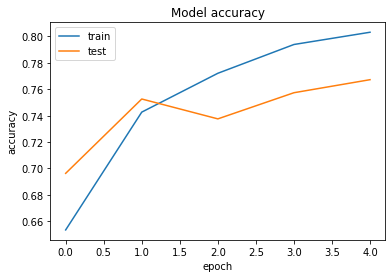

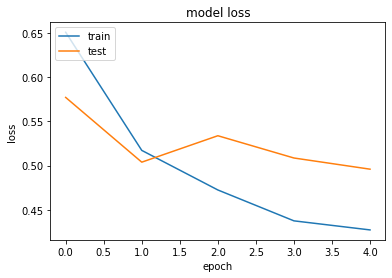

Model 2


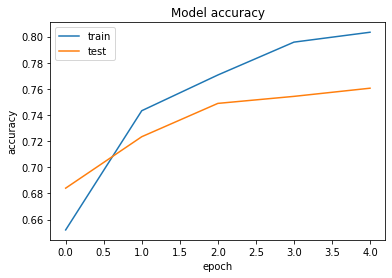

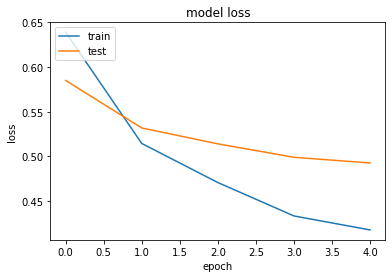

Model 3


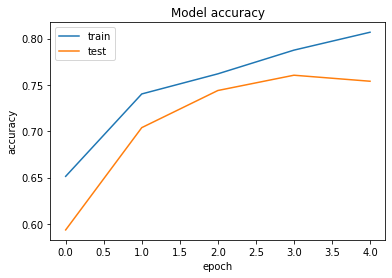

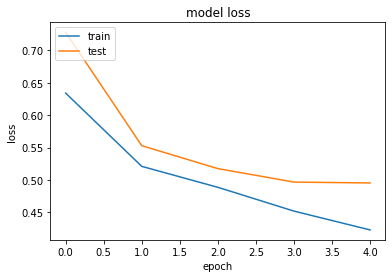

In [19]:
import matplotlib.pyplot as plt


print("Model 1")
plt.plot(track.history['accuracy'])
plt.plot(track.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(track.history['loss'])
plt.plot(track.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Model 2")
plt.plot(track2.history['accuracy'])
plt.plot(track2.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(track2.history['loss'])
plt.plot(track2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Model 3")
plt.plot(track3.history['accuracy'])
plt.plot(track3.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(track3.history['loss'])
plt.plot(track3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
df_test = pd.DataFrame({'true': y_test.tolist(), 'pred':pred_classes})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

df_test2 = pd.DataFrame({'true': y_test.tolist(), 'pred':pred_classes2})
df_test2['true'] = df_test2['true'].apply(lambda x: np.argmax(x))

df_test3 = pd.DataFrame({'true': y_test.tolist(), 'pred':pred_classes3})
df_test3['true'] = df_test3['true'].apply(lambda x: np.argmax(x))

print("confusion matrix: Model 1 \n",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))
print("\n")

print("confusion matrix: Model 2 \n",confusion_matrix(df_test2.true, df_test2.pred))
print(classification_report(df_test2.true, df_test2.pred))
print("\n")

print("confusion matrix: Model 3 \n",confusion_matrix(df_test3.true, df_test3.pred))
print(classification_report(df_test3.true, df_test3.pred))
print("\n")

confusion matrix: Model 1 
 [[6969 3024]
 [1745 8262]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      9993
           1       0.73      0.83      0.78     10007

    accuracy                           0.76     20000
   macro avg       0.77      0.76      0.76     20000
weighted avg       0.77      0.76      0.76     20000



confusion matrix: Model 2 
 [[6796 3197]
 [1677 8330]]
              precision    recall  f1-score   support

           0       0.80      0.68      0.74      9993
           1       0.72      0.83      0.77     10007

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.75     20000
weighted avg       0.76      0.76      0.75     20000



confusion matrix: Model 3 
 [[6638 3355]
 [1697 8310]]
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      9993
           1       0.71      0.83      0.77     10007

    accuracy 

In [22]:
print('Save model...')
model.save('Model/LSTMWord2vec_model1_rev.h5')
model2.save('Model/LSTMWord2vec_model2_rev.h5')
model3.save('Model/LSTMWord2vec_model3_rev.h5')

model_json = model.to_json()
with open("Model/LSTMWord2vec_model1_rev.json", "w") as json_file:
    json_file.write(model_json)
    
model2_json = model2.to_json()
with open("Model/LSTMWord2vec_model2_rev.json", "w") as json_file:
    json_file.write(model2_json)
    
model3_json = model3.to_json()
with open("Model/LSTMWord2vec_model3_rev.json", "w") as json_file:
    json_file.write(model3_json)
    
print('Model saved...')

Save model...
Model saved...


In [23]:
twt = ["I still don't know how these people are open for business. The food is disgusting. The delivery charge to go half a mile is $25. Half the time they're not even open. They may be very friendly people who own the business I'm not sure. But it isn't even worth it if you're drunk"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=maxlen, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 1)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 [==============================] - 0s 1ms/step
[0.65963054 0.34329355]
negative


In [24]:
twt = ["Came for lunch with my sister. We loved our Thai-style mains which were amazing with lots of flavour, very impressive for a vegetarian restaurant."]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=maxlen, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 1)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 [==============================] - 0s 1ms/step
[0.06156025 0.9381933 ]
positive


In [25]:
twt = ["Delicious pizza and wings late night delivery amazing service and the right price to pay for 24hr restaurant!!!"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=maxlen, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 1)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 [==============================] - 0s 1ms/step
[0.08796339 0.9116835 ]
positive


In [26]:
twt = ["I was wondering what was taking long... the place was filled with no one and it Almost took an hour for the food... then the food finnaly arrived and guess what we were served... Cold pizza, cold wings and drinks were so watery"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=maxlen, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 1)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 [==============================] - 0s 1ms/step
[0.7311914 0.2671818]
negative


In [27]:
twt = ["The best in Wisconsin and being the dairy state thats saying a lot The ice cream is a great consistency and there are so many creative flavors like cake batter fudge zanziberry shortcake and sht just got serious Staff tends to be local kids which gives a nice friendly tone to the shop They also sell fudge candy and other treats This is a must stop in Madison for some good ice cream"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = sequence.pad_sequences(twt, maxlen=maxlen, dtype='int32', value=0)
# print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 1)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 [==============================] - 0s 1ms/step
[0.03650671 0.9635484 ]
positive


In [28]:
from keras.utils.vis_utils import plot_model

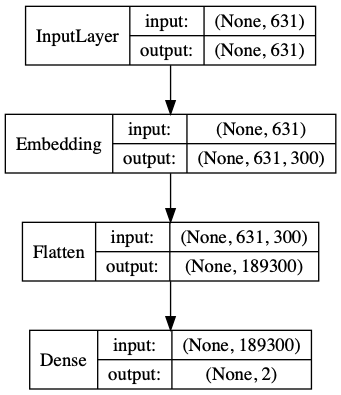

In [29]:
plot_model(model, to_file='model_word2vec_lstm.png', show_shapes=True, show_layer_names=False)

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Model/LSTMWord2vec_model1.h5')
# summarize model.
model.summary()